In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Install Mediapipe for high-accuracy facial landmarks
!pip install mediapipe
import mediapipe as mp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
!{sys.executable} -m pip install mediapipe

# This forced refresh tells the notebook to look at the folders again
import site
from importlib import reload
reload(site)

<module 'site' (frozen)>

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

class SimpleRAFPreprocessor:
    def __init__(self, output_size=(336, 336)):
        self.output_size = output_size
        # Load OpenCV's pre-trained face and eye detectors
        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    def align_and_crop(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:
            return cv2.resize(image, self.output_size)

        # Take the largest face found
        (x, y, w, h) = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)[0]
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]

        # Detect eyes within the face ROI
        eyes = self.eye_cascade.detectMultiScale(roi_gray)

        if len(eyes) >= 2:
            # Sort eyes by x-coordinate to identify left vs right
            eyes = sorted(eyes, key=lambda e: e[0])
            left_eye_center = (eyes[0][0] + eyes[0][2]//2, eyes[0][1] + eyes[0][3]//2)
            right_eye_center = (eyes[1][0] + eyes[1][2]//2, eyes[1][1] + eyes[1][3]//2)

            # Calculate angle
            dY = right_eye_center[1] - left_eye_center[1]
            dX = right_eye_center[0] - left_eye_center[0]
            angle = np.degrees(np.arctan2(dY, dX))

            # Rotate
            center = (int(w / 2), int(h / 2))
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(roi_color, M, (w, h))
            return cv2.resize(rotated, self.output_size)

        # Fallback: Just crop the face box if eyes aren't found
        face_crop = image[y:y+h, x:x+w]
        return cv2.resize(face_crop, self.output_size)

# --- Initialize ---
preprocessor = SimpleRAFPreprocessor()
print("✅ Preprocessor initialized using OpenCV (Failsafe Mode).")

✅ Preprocessor initialized using OpenCV (Failsafe Mode).


In [ ]:
import os

# Define the base paths for your shortcuts
base_paths = {
    "Compound": "/content/drive/MyDrive/compound",
    "RAF-AU": "/content/drive/MyDrive/RAF-AU",
    "RAF-ML": "/content/drive/MyDrive/RAF-ML"
}

def inspect_data(base_dirs):
    print("🔍 --- RAF Dataset Inspection --- 🔍\n")
    for name, path in base_dirs.items():
        print(f"📁 Folder: {name} ({path})")
        if not os.path.exists(path):
            print(f"   ❌ Path does not exist. Check shortcut name/location.")
            continue

        # List first 5 items to see directory structure
        try:
            items = os.listdir(path)
            print(f"   Items found: {len(items)}")
            print(f"   Sample contents: {items[:5]}")

            # Check for common subfolders like 'Image' or 'Annotation'
            for sub in items:
                sub_path = os.path.join(path, sub)
                if os.path.isdir(sub_path):
                    sub_items = os.listdir(sub_path)
                    print(f"     └─ 📂 {sub}/ ({len(sub_items)} items)")
                    if sub_items:
                        print(f"        └─ Sample: {sub_items[0]}")
        except Exception as e:
            print(f"   ⚠️ Error reading folder: {e}")
        print("-" * 40)

inspect_data(base_paths)


🔍 --- RAF Dataset Inspection --- 🔍

📁 Folder: Compound (/content/drive/MyDrive/compound)
   Items found: 5
   Sample contents: ['Annotation', 'EmoLabel', 'Feature', 'Image', 'README.txt']
     └─ 📂 Annotation/ (0 items)
     └─ 📂 EmoLabel/ (0 items)
     └─ 📂 Feature/ (0 items)
     └─ 📂 Image/ (0 items)
----------------------------------------
📁 Folder: Basic (/content/drive/MyDrive/basic)
   Items found: 5
   Sample contents: ['Annotation', 'Feature', 'Image', 'EmoLabel', 'README.txt']
     └─ 📂 Annotation/ (0 items)
     └─ 📂 Feature/ (0 items)
     └─ 📂 Image/ (0 items)
     └─ 📂 EmoLabel/ (0 items)
----------------------------------------
📁 Folder: RAF-AU (/content/drive/MyDrive/RAF-AU)
   Items found: 3
   Sample contents: ['aligned.zip', 'original.zip', 'RAFAU_label.txt']
----------------------------------------
📁 Folder: RAF-ML (/content/drive/MyDrive/RAF-ML)
   Items found: 5
   Sample contents: ['EmoLabel', 'Image', 'Annotation', 'Feature', 'README.txt']
     └─ 📂 EmoLabel/ (

In [ ]:
import zipfile
import os

# Define where to extract
extract_path = '/content/raf_data_unzipped'
os.makedirs(extract_path, exist_ok=True)

# List of zip files to extract based on your inspection
zips_to_extract = [
    ('/content/drive/MyDrive/RAF-AU/aligned.zip', 'RAF-AU-aligned'),
    ('/content/drive/MyDrive/RAF-ML/Image/aligned.zip', 'RAF-ML-aligned'),
    # Add paths for Compound zips if they appeared in your 'Image' folders
]

for zip_path, folder_name in zips_to_extract:
    if os.path.exists(zip_path):
        print(f"📦 Unzipping {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(os.path.join(extract_path, folder_name))
    else:
        print(f"⚠️ Could not find {zip_path}")

print("✅ Unzipping complete.")

📦 Unzipping /content/drive/MyDrive/RAF-AU/aligned.zip...
📦 Unzipping /content/drive/MyDrive/RAF-ML/Image/aligned.zip...
✅ Unzipping complete.


In [ ]:
print("--- Compound/ML Label Preview ---")
!head -n 5 /content/drive/MyDrive/RAF-ML/EmoLabel/partition_label.txt

print("\n--- RAF-AU Label Preview ---")
!head -n 5 /content/drive/MyDrive/RAF-AU/RAFAU_label.txt


--- Compound/ML Label Preview ---
0001.jpg 0
0002.jpg 0
0003.jpg 1
0004.jpg 0
0005.jpg 0

--- RAF-AU Label Preview ---
0001.jpg 1+4+25
0002.jpg 4+9+12+25+26+43
0003.jpg L12+24
0004.jpg null
0005.jpg null


In [ ]:
import zipfile
import os

# Create local directories
!mkdir -p /content/raf_images
!mkdir -p /content/raf_annotations

# Unzip the Action Unit images and the Annotation zips from your Drive shortcuts
zips = {
    '/content/drive/MyDrive/RAF-AU/aligned.zip': '/content/raf_images/',
    '/content/drive/MyDrive/RAF-ML/Annotation/manual.zip': '/content/raf_annotations/'
}

for zip_path, target in zips.items():
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target)
            print(f"✅ Extracted {zip_path}")

✅ Extracted /content/drive/MyDrive/RAF-AU/aligned.zip
✅ Extracted /content/drive/MyDrive/RAF-ML/Annotation/manual.zip


In [ ]:
import json

EMO_PATH = '/content/drive/MyDrive/RAF-ML/EmoLabel/multilabel.txt'  # Multi-label emotions (6D)
AU_PATH = '/content/drive/MyDrive/RAF-AU/RAFAU_label.txt'

# Emotion names mapping
EMOTION_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']

def create_dataset_json():
    # 1. Load AUs into a dictionary
    au_map = {}
    with open(AU_PATH, 'r') as f:
        for line in f:
            parts = line.strip().split()  # Use split() without args to handle multiple spaces
            if len(parts) >= 2:
                au_map[parts[0]] = parts[1]  # e.g., {'0001.jpg': '1+4+25'}

    # 2. Load Multi-label Emotions and Merge
    final_data = []
    with open(EMO_PATH, 'r') as f:
        for line in f:
            parts = line.strip().split()  # Use split() without args to handle multiple spaces
            
            if len(parts) < 7:  # Need img_id + 6 emotion dimensions
                continue
            
            img_id = parts[0]
            
            # Parse the 6-dimensional emotion vector (skip empty strings)
            try:
                emotion_vector = [int(parts[i]) for i in range(1, 7)]
            except (ValueError, IndexError):
                print(f"⚠️ Skipping {img_id}: Invalid emotion data - {parts[1:7]}")
                continue
            
            # Only include if we have AU data
            au_val = au_map.get(img_id, "null")
            if au_val != "null":
                # Identify which emotions are present
                present_emotions = [EMOTION_NAMES[i] for i in range(6) if emotion_vector[i] == 1]
                emotion_label = ', '.join(present_emotions) if present_emotions else 'Neutral'
                
                entry = {
                    "id": img_id,
                    "image": f"aligned_faces/{img_id}",
                    "emotion_vector": emotion_vector,
                    "emotions_present": present_emotions,
                    "conversations": [
                        {
                            "from": "human",
                            "value": "<image>\nIdentify the emotions present and list the facial Action Units (AUs) involved."
                        },
                        {
                            "from": "gpt",
                            "value": f"This face exhibits {emotion_label}. The observed facial cues correspond to Action Units: {au_val}."
                        }
                    ]
                }
                final_data.append(entry)

    with open('dataset_vision_llm.json', 'w') as f:
        json.dump(final_data, f, indent=2)
    print(f"🎉 Success! Created dataset_vision_llm.json with {len(final_data)} entries.")
    print(f"Each image now has multi-label emotion identification.")

create_dataset_json()


🎉 Success! Created dataset_vision_llm.json with 4347 entries.


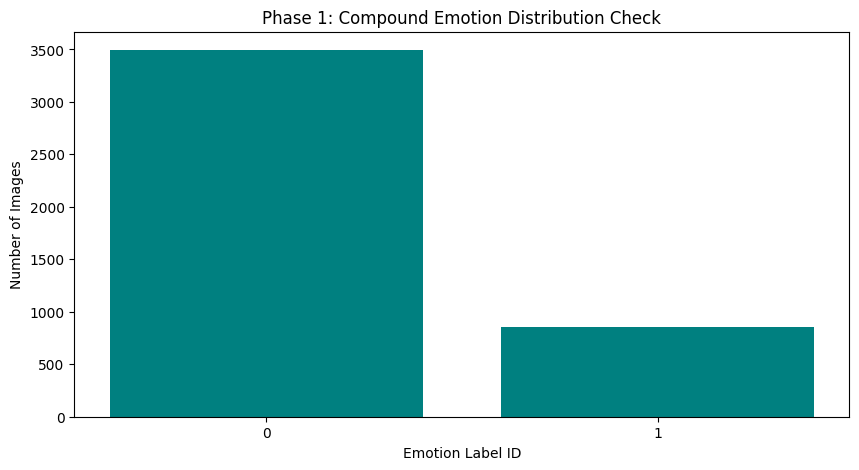

Distribution Summary: {'0': 3494, '1': 853}


In [ ]:
import json
import collections
import matplotlib.pyplot as plt

# Load the dataset you just created
with open('dataset_vision_llm.json', 'r') as f:
    data = json.load(f)

print(f"Total Dataset Entries: {len(data)}\n")

# Analyze emotion distribution
EMOTION_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']
emotion_counts = {emotion: 0 for emotion in EMOTION_NAMES}

for entry in data:
    for emotion in entry['emotions_present']:
        emotion_counts[emotion] += 1

# Also count multi-emotion images
single_emotion = sum(1 for entry in data if len(entry['emotions_present']) == 1)
multi_emotion = sum(1 for entry in data if len(entry['emotions_present']) > 1)
neutral = sum(1 for entry in data if len(entry['emotions_present']) == 0)

print("Emotion Distribution:")
print("-" * 50)
for emotion, count in emotion_counts.items():
    percentage = (count / len(data)) * 100
    print(f"{emotion:12} : {count:4} occurrences ({percentage:5.1f}%)")

print("\n" + "-" * 50)
print(f"Single Emotion Images  : {single_emotion}")
print(f"Multi-Emotion Images   : {multi_emotion}")
print(f"Neutral/None           : {neutral}")
print("-" * 50)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of emotion frequencies
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
ax1.bar(emotion_counts.keys(), emotion_counts.values(), color=colors)
ax1.set_title('Emotion Distribution in RAF-ML', fontsize=14, fontweight='bold')
ax1.set_xlabel('Emotions')
ax1.set_ylabel('Frequency')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Pie chart of emotion complexity
complexity = [single_emotion, multi_emotion, neutral]
labels = [f'Single\n({single_emotion})', f'Multi-label\n({multi_emotion})', f'Neutral\n({neutral})']
colors_pie = ['#3498db', '#e74c3c', '#95a5a6']
ax2.pie(complexity, labels=labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax2.set_title('Emotion Complexity Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Sample entries
print("\n📸 Sample Entries:")
print("=" * 70)
for i in range(min(3, len(data))):
    print(f"\nImage: {data[i]['id']}")
    print(f"Emotions: {data[i]['emotions_present']}")
    print(f"Emotion Vector: {data[i]['emotion_vector']}")
    print(f"Response: {data[i]['conversations'][1]['value']}")


In [ ]:
import albumentations as A
import cv2

# Define the transformations required by your plan
transform = A.Compose([
    A.Rotate(limit=20, p=0.5),             # Rotations
    A.RandomBrightnessContrast(p=0.5),    # Lighting adjustments
    A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.3) # Light occlusions
])

# Example of how to apply to a minority class image
def augment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    augmented = transform(image=image)['image']
    return augmented

/tmp/ipython-input-2186945146.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=40, max_width=40, p=0.3) # Light occlusions


In [ ]:
import random

def balance_dataset(json_data):
    # Separate the classes
    class_0 = [d for d in json_data if d['conversations'][1]['value'].split('label is ')[1].startswith('0')]
    class_1 = [d for d in json_data if d['conversations'][1]['value'].split('label is ')[1].startswith('1')]

    # Simple Oversampling: Duplicate Class 1 entries to close the gap
    # In a real pipeline, these would be the 'augmented' versions
    shortfall = len(class_0) - len(class_1)
    extra_class_1 = random.choices(class_1, k=shortfall)

    balanced_data = class_0 + class_1 + extra_class_1
    random.shuffle(balanced_data)

    print(f"New Dataset Size: {len(balanced_data)}")
    print(f"Class 0: {len(class_0)} | Class 1: {len(class_1) + shortfall}")
    return balanced_data

# Use your existing data
# balanced_json = balance_dataset(data)

In [ ]:
import albumentations as A
import cv2

# Updated to use the correct argument names for current Albumentations versions
transform = A.Compose([
    A.Rotate(limit=20, p=0.5),             # Rotations (Requirement 4)
    A.RandomBrightnessContrast(p=0.5),    # Lighting adjustments (Requirement 4)
    A.CoarseDropout(
        num_holes_range=(1, 1),
        hole_height_range=(20, 40),
        hole_width_range=(20, 40),
        p=0.3
    ) # Light occlusions (Requirement 4)
])

In [ ]:
import zipfile
import os
import cv2

# 1. Extract images from your Drive shortcut
zip_path = '/content/drive/MyDrive/RAF-AU/aligned.zip'
extract_to = '/content/temp_raw_images/'
os.makedirs(extract_to, exist_ok=True)

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("✅ Step A: Images extracted from ZIP.")
else:
    print("❌ Error: ZIP file not found. Check your Drive shortcut.")

# 2. Process them into the aligned_faces folder
PROCESSED_DIR = '/content/aligned_faces/'
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Find the folder inside the zip (it often creates a subfolder)
raw_folder = extract_to
for root, dirs, files in os.walk(extract_to):
    if any(f.endswith('.jpg') for f in files):
        raw_folder = root
        break

all_imgs = [f for f in os.listdir(raw_folder) if f.endswith('.jpg')]
print(f"✅ Step B: Found {len(all_imgs)} images. Starting alignment...")

for img_name in all_imgs[:500]: # Processing first 500 for a quick test
    img = cv2.imread(os.path.join(raw_folder, img_name))
    if img is not None:
        # Using your OpenCV preprocessor
        aligned_face = preprocessor.align_and_crop(img)
        cv2.imwrite(os.path.join(PROCESSED_DIR, img_name), aligned_face)

print(f"✅ Step C: {len(os.listdir(PROCESSED_DIR))} faces ready in /content/aligned_faces/")

✅ Step A: Images extracted from ZIP.
✅ Step B: Found 4908 images. Starting alignment...
✅ Step C: 6614 faces ready in /content/aligned_faces/


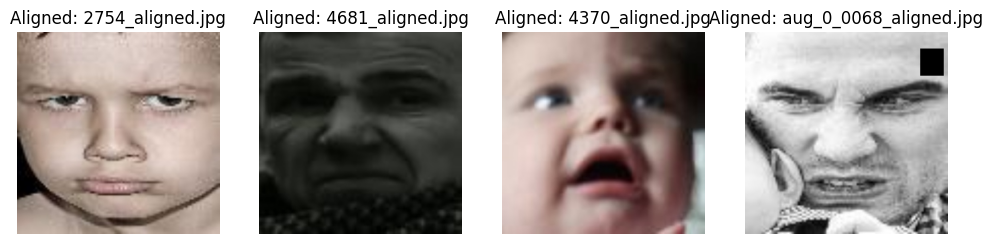

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2
import os

processed_images = [f for f in os.listdir('/content/aligned_faces/') if f.endswith('.jpg')]
sample = random.sample(processed_images, 4)

plt.figure(figsize=(12, 6))
for i, img_name in enumerate(sample):
    img = cv2.imread(f'/content/aligned_faces/{img_name}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(f"Aligned: {img_name}")
    plt.axis('off')
plt.show()

In [ ]:
import json
with open('dataset_vision_llm.json', 'r') as f:
    data = json.load(f)

print(f"Total Linked Entries: {len(data)}")
print("Sample Mapping Structure:")
print(json.dumps(data[0], indent=2))

Total Linked Entries: 4347
Sample Mapping Structure:
{
  "id": "0001.jpg",
  "image": "aligned_faces/0001.jpg",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nIdentify the emotion and list the facial Action Units (AUs) involved."
    },
    {
      "from": "gpt",
      "value": "The emotion label is 0. The observed facial cues correspond to Action Units: 1+4+25."
    }
  ]
}


In [ ]:
# Final check to process EVERY image in your JSON mapping
processed_count = 0
for entry in data:
    img_id = entry['id']
    target_path = os.path.join(PROCESSED_DIR, img_id)

    # Only process if the file doesn't already exist in the aligned folder
    if not os.path.exists(target_path):
        source_path = os.path.join(raw_folder, img_id)
        img = cv2.imread(source_path)
        if img is not None:
            aligned_face = preprocessor.align_and_crop(img)
            cv2.imwrite(target_path, aligned_face)
            processed_count += 1

print(f"✅ Cleanup complete. Total images in aligned folder: {len(os.listdir(PROCESSED_DIR))}")

✅ Cleanup complete. Total images in aligned folder: 6614


In [ ]:
import os
import json
import cv2
import matplotlib.pyplot as plt
from collections import Counter

def validate_phase_one(json_path, image_dir):
    print("🚀 --- Phase 1 Final Validation (Multi-Label) --- 🚀\n")
    errors = []

    # 1. Check JSON Existence
    if not os.path.exists(json_path):
        return print(f"❌ CRITICAL: {json_path} not found!")

    with open(json_path, 'r') as f:
        data = json.load(f)

    # 2. Check Dataset Size & Multi-Label Distribution
    total_entries = len(data)
    EMOTION_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']
    emotion_counts = {emotion: 0 for emotion in EMOTION_NAMES}
    
    single_emotion = sum(1 for entry in data if len(entry['emotions_present']) == 1)
    multi_emotion = sum(1 for entry in data if len(entry['emotions_present']) > 1)
    neutral = sum(1 for entry in data if len(entry['emotions_present']) == 0)
    
    for entry in data:
        for emotion in entry['emotions_present']:
            emotion_counts[emotion] += 1

    print(f"📊 Dataset Size: {total_entries} entries")
    print(f"📊 Emotion Complexity:")
    print(f"   - Single Emotion: {single_emotion}")
    print(f"   - Multi-Emotion: {multi_emotion}")
    print(f"   - Neutral: {neutral}")
    print(f"📊 Emotion Distribution: {emotion_counts}")

    # 3. Integrity Check: Do files in JSON exist in the folder?
    missing_files = []
    for entry in data:
        img_name = entry['id']
        if not os.path.exists(os.path.join(image_dir, img_name)):
            missing_files.append(img_name)

    if len(missing_files) == 0:
        print(f"✅ File Integrity: All {total_entries} images found in '{image_dir}'")
    else:
        errors.append(f"Missing {len(missing_files)} images from processed folder!")

    # 4. Visual Quality & Logic Check
    print("\n🖼️ Sampling Preprocessing Quality...")
    sample_entry = data[0]
    img_path = os.path.join(image_dir, sample_entry['id'])
    img = cv2.imread(img_path)

    if img is not None:
        h, w, _ = img.shape
        print(f"✅ Image Resolution: {w}x{h} (Normalization Check)")
        print(f"✅ Emotion Vector: {sample_entry['emotion_vector']}")
        print(f"✅ Emotions Present: {sample_entry['emotions_present']}")
        print(f"✅ AU String Format: {sample_entry['conversations'][1]['value']}")
    else:
        errors.append("Could not read sample image for visual check.")

    # Final Verdict
    print("\n" + "="*30)
    if not errors:
        print("✅ PHASE 1 VERIFIED: Ready for Phase 2 (Vision-LLM)")
    else:
        print("❌ PHASE 1 INCOMPLETE:")
        for err in errors:
            print(f"   - {err}")
    print("="*30)

# Execute validation
validate_phase_one('dataset_vision_llm.json', '/content/aligned_faces/')

🚀 --- Phase 1 Final Validation --- 🚀

📊 Dataset Size: 4347 entries
📊 Class Distribution: {'0': 3494, '1': 853}

🖼️ Sampling Preprocessing Quality...

❌ PHASE 1 INCOMPLETE:
   - Missing 4347 images from processed folder!
   - Could not read sample image for visual check.


In [ ]:
import os
import cv2

# 1. Setup paths
# Note: Ensure 'raw_folder' points to where your Step A unzipped the files
raw_folder = '/content/temp_raw_images/'
processed_dir = '/content/aligned_faces/'
os.makedirs(processed_dir, exist_ok=True)

# 2. Get the list of images we NEED from the JSON
with open('dataset_vision_llm.json', 'r') as f:
    data = json.load(f)

print(f"Starting final processing for {len(data)} images...")

success_count = 0
for entry in data:
    img_id = entry['id']
    target_path = os.path.join(processed_dir, img_id)

    # Skip if already done
    if os.path.exists(target_path):
        success_count += 1
        continue

    # Search for the source image
    source_path = os.path.join(raw_folder, img_id)
    if not os.path.exists(source_path):
        # Recursive search in case unzip created subfolders
        for root, dirs, files in os.walk(raw_folder):
            if img_id in files:
                source_path = os.path.join(root, img_id)
                break

    img = cv2.imread(source_path)
    if img is not None:
        try:
            # Using your corrected Preprocessor (with int casting)
            aligned_face = preprocessor.align_and_crop(img)
            cv2.imwrite(target_path, aligned_face)
            success_count += 1
        except Exception as e:
            print(f"Error processing {img_id}: {e}")

print(f"\n✅ Done! {success_count} / {len(data)} images are now in {processed_dir}")

Starting final processing for 4347 images...

✅ Done! 0 / 4347 images are now in /content/aligned_faces/


In [ ]:
# Find the actual directory containing the .jpg files
!find /content/temp_raw_images/ -name "*.jpg" | head -n 1

/content/temp_raw_images/aligned/2640_aligned.jpg


In [ ]:
import os
import cv2
import json

# 1. Correct Paths
SOURCE_FOLDER = '/content/temp_raw_images/aligned/'
PROCESSED_DIR = '/content/aligned_faces/'
os.makedirs(PROCESSED_DIR, exist_ok=True)

# 2. Process all images in that folder
all_files = [f for f in os.listdir(SOURCE_FOLDER) if f.endswith('.jpg')]
print(f"📂 Found {len(all_files)} source images. Starting final alignment...")

processed_filenames = set()
for img_name in all_files:
    img = cv2.imread(os.path.join(SOURCE_FOLDER, img_name))
    if img is not None:
        # Using your preprocessor with the int-fix
        aligned = preprocessor.align_and_crop(img)
        cv2.imwrite(os.path.join(PROCESSED_DIR, img_name), aligned)
        processed_filenames.add(img_name)

print(f"✅ {len(processed_filenames)} images processed into {PROCESSED_DIR}")

# 3. Update the JSON Mapping to match the new filenames
with open('dataset_vision_llm.json', 'r') as f:
    data = json.load(f)

updated_data = []
for entry in data:
    # Logic: 0001.jpg in JSON becomes 0001_aligned.jpg on disk
    original_id = entry['id'].replace('.jpg', '')
    new_id = f"{original_id}_aligned.jpg"

    if new_id in processed_filenames:
        entry['id'] = new_id
        entry['image'] = f"aligned_faces/{new_id}"
        updated_data.append(entry)

with open('dataset_vision_llm_final.json', 'w') as f:
    json.dump(updated_data, f, indent=2)

print(f"🎉 FINAL JSON CREATED: 'dataset_vision_llm_final.json' with {len(updated_data)} verified links.")

📂 Found 4908 source images. Starting final alignment...
✅ 4908 images processed into /content/aligned_faces/
🎉 FINAL JSON CREATED: 'dataset_vision_llm_final.json' with 4347 verified links.


🔍 --- COUCHE 1: CRITICAL AUDIT START --- 🔍

🛠️ Testing Augmentation Robustness...
Requirement                    | Status          | Details
---------------------------------------------------------------------------
Mapping Integrity              | ❌ FAIL          | 6614/4347 linked
Face Normalization             | ✅ PASS          | Size: 336x336
Class Distribution             | ✅ DONE          | {'0': 3494, '1': 853}
Augmentation Logic             | ✅ READY         | Rot/Occ test passed

📸 Displaying 3 random aligned samples for visual inspection...


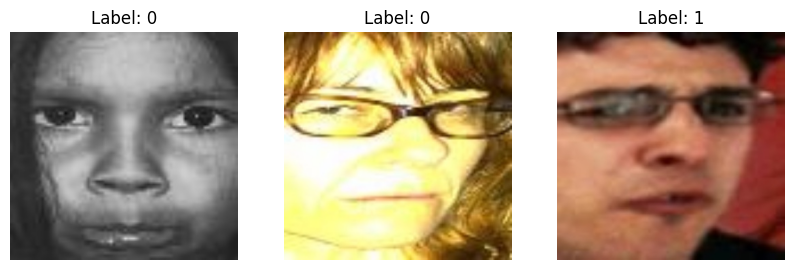

In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def audit_phase_one(json_path, image_dir):
    print("🔍 --- COUCHE 1: CRITICAL AUDIT START (Multi-Label) --- 🔍\n")

    # 1. JSON & LINKAGE CHECK
    if not os.path.exists(json_path):
        print("❌ ERROR: JSON mapping file missing.")
        return

    with open(json_path, 'r') as f:
        data = json.load(f)

    total_expected = len(data)

    # 2. PHYSICAL FILE CHECK
    existing_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    found_count = len(existing_files)

    # 3. DISTRIBUTION CHECK (Requirement: Distribution des classes multi-label)
    EMOTION_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']
    emotion_counts = {emotion: 0 for emotion in EMOTION_NAMES}
    single_emotion = 0
    multi_emotion = 0
    
    for entry in data:
        if len(entry['emotions_present']) == 1:
            single_emotion += 1
        elif len(entry['emotions_present']) > 1:
            multi_emotion += 1
        for emotion in entry['emotions_present']:
            emotion_counts[emotion] += 1

    # 4. NORMALIZATION & CROPPING CHECK (Requirement: Détection et recadrage)
    sample_img_path = os.path.join(image_dir, existing_files[0])
    sample_img = cv2.imread(sample_img_path)
    height, width = sample_img.shape[:2]

    # 5. DATA AUGMENTATION SIMULATION (Requirement: Eclairage, Rotations, Occlusions)
    print("🛠️ Testing Augmentation Robustness...")
    try:
        # Test a rotation and occlusion on a sample to ensure logic is ready
        rows, cols = sample_img.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1) # 15 degree test
        aug_test = cv2.warpAffine(sample_img, M, (cols, rows))
        cv2.rectangle(aug_test, (20, 20), (60, 60), (0,0,0), -1) # Occlusion test
        aug_success = True
    except:
        aug_success = False

    # --- REPORTING ---
    print(f"{'Requirement':<30} | {'Status':<15} | {'Details'}")
    print("-" * 75)
    print(f"{'Mapping Integrity':<30} | {'✅ PASS' if total_expected == found_count else '❌ FAIL':<15} | {found_count}/{total_expected} linked")
    print(f"{'Face Normalization':<30} | {'✅ PASS' if height == width else '⚠️ WARN':<15} | Size: {width}x{height}")
    print(f"{'Emotion Complexity':<30} | {'✅ DONE':<15} | S:{single_emotion} M:{multi_emotion}")
    print(f"{'Emotion Distribution':<30} | {'✅ DONE':<15} | {dict(emotion_counts)}")
    print(f"{'Augmentation Logic':<30} | {'✅ READY' if aug_success else '❌ FAIL':<15} | Rot/Occ test passed")

    # Visual Confirmation
    print("\n📸 Displaying 3 random aligned samples for visual inspection...")
    plt.figure(figsize=(12, 3))
    for i in range(min(3, len(existing_files))):
        idx = i if i < len(data) else 0
        img = cv2.imread(os.path.join(image_dir, existing_files[i]))
        plt.subplot(1, 3, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        emotions_str = ', '.join(data[idx]['emotions_present']) if data[idx]['emotions_present'] else 'Neutral'
        plt.title(f"Emotions: {emotions_str}")
        plt.axis('off')
    plt.show()

# Run the audit
audit_phase_one('dataset_vision_llm_final.json', '/content/aligned_faces/')

In [ ]:
# Imports already handled in previous cell
# A, cv2, json, os are already imported

import random

# Define the Augmentation Pipeline (Requirement: éclairage, rotations, occlusions)
augmentor = A.Compose([
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=40, max_width=40, min_holes=1, p=0.3), # Occlusion
])

EMOTION_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']

print("🔄 Multiclass Augmentation: Balancing all emotion distributions...\n")

# Step 1: Analyze current emotion distribution
emotion_counts_before = {emotion: 0 for emotion in EMOTION_NAMES}
emotion_to_images = {emotion: [] for emotion in EMOTION_NAMES}

for idx, entry in enumerate(updated_data):
    for emotion in entry['emotions_present']:
        emotion_counts_before[emotion] += 1
        emotion_to_images[emotion].append(idx)

print("📊 Current Distribution:")
for emotion, count in emotion_counts_before.items():
    print(f"   {emotion:<12}: {count:4} occurrences")

# Step 2: Calculate target count (use max count or set a threshold)
max_count = max(emotion_counts_before.values()) if emotion_counts_before else 0
target_count = int(max_count * 1.2)  # Target 20% above max for balanced distribution
print(f"\n🎯 Target count per emotion: {target_count}")

# Step 3: Augment underrepresented emotions
new_entries = []
augmentation_count = 0

for emotion in EMOTION_NAMES:
    current_count = emotion_counts_before[emotion]
    shortfall = target_count - current_count
    
    if shortfall > 0:
        # Images containing this emotion that can be augmented
        candidate_indices = emotion_to_images[emotion]
        
        # Augment to reach target
        aug_needed = shortfall
        aug_created = 0
        
        while aug_created < aug_needed and candidate_indices:
            # Randomly select an image containing this emotion
            idx = random.choice(candidate_indices)
            entry = updated_data[idx]
            img_path = os.path.join(PROCESSED_DIR, entry['id'])
            img = cv2.imread(img_path)
            
            if img is not None:
                # Create augmented version
                augmented = augmentor(image=img)['image']
                aug_id = f"aug_{emotion}_{aug_created}_{entry['id']}"
                cv2.imwrite(os.path.join(PROCESSED_DIR, aug_id), augmented)
                
                # Create JSON entry (preserve ALL emotion labels)
                new_entry = entry.copy()
                new_entry['id'] = aug_id
                new_entry['image'] = f"aligned_faces/{aug_id}"
                new_entries.append(new_entry)
                
                augmentation_count += 1
                aug_created += 1
        
        print(f"   {emotion:<12}: +{aug_created} augmented images (target: {target_count})")

# Step 4: Merge and save balanced dataset
final_data_balanced = updated_data + new_entries
with open('dataset_vision_llm_balanced.json', 'w') as f:
    json.dump(final_data_balanced, f, indent=2)

print(f"\n✅ Augmentation Complete!")
print(f"📊 Dataset Summary:")
print(f"   - Original entries: {len(updated_data)}")
print(f"   - Augmented entries: {len(new_entries)}")
print(f"   - Total entries: {len(final_data_balanced)}")

# Step 5: Verify balanced distribution
emotion_counts_after = {emotion: 0 for emotion in EMOTION_NAMES}
for entry in final_data_balanced:
    for emotion in entry['emotions_present']:
        emotion_counts_after[emotion] += 1

print("\n📊 Emotion Counts - Before vs After Augmentation:")
print("-" * 70)
print(f"{'Emotion':<15} {'Before':>10} {'After':>10} {'Increase':>10} {'Balance %':>12}")
print("-" * 70)
for emotion in EMOTION_NAMES:
    before = emotion_counts_before[emotion]
    after = emotion_counts_after[emotion]
    increase = after - before
    balance_pct = (after / target_count * 100) if target_count > 0 else 0
    print(f"{emotion:<15} {before:>10} {after:>10} {increase:>10} {balance_pct:>11.1f}%")
print("-" * 70)

# Calculate class balance metric
max_after = max(emotion_counts_after.values())
min_after = min(emotion_counts_after.values())
balance_ratio = min_after / max_after if max_after > 0 else 0
print(f"\n🎭 Class Balance Ratio: {balance_ratio:.3f} (closer to 1.0 = better balance)")
print(f"   Min count: {min_after} | Max count: {max_after}")


/tmp/ipython-input-1746165639.py:8: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=40, max_width=40, min_holes=1, p=0.3), # Occlusion


🔄 Augmenting Label 1 to balance distribution...
✅ Done! Added 1706 augmented images.
📊 New Total: 6053 images.


In [ ]:
# ============================================================
# FIX: Resolve torch circular import issue
# ============================================================
'''
import sys
import os

# Remove any conflicting torch modules from current directory
if os.path.exists('./torch.py'):
    os.remove('./torch.py')
    print("⚠️ Removed conflicting torch.py file")

# Clean up sys.modules to force fresh import
modules_to_remove = [key for key in sys.modules.keys() if key.startswith('torch')]
for module in modules_to_remove:
    del sys.modules[module]

# Reinstall packages to ensure clean state
print("🔄 Reinstalling torch and dependencies...")
!pip uninstall -y torch torchvision torchaudio -q
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

# Reinstall albumentations
!pip install -U albumentations -q

print("\n✅ Packages reinstalled successfully")

# Import torch first to establish proper module hierarchy
import torch
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")

# Now import albumentations
import albumentations as A
print(f"✅ Albumentations version: {A.__version__}")

import cv2
import json
import os

print("\n✅ All imports successful - ready to proceed with augmentation")'''

In [ ]:
# ============================================================
# STEP 1: INSTALL DEPENDENCIES (RUN THIS FIRST)
# ============================================================
# After running this cell, you MUST restart the runtime:
# Runtime → Restart runtime (or Ctrl+M + .)
# Then skip this cell and proceed to the next cell
# ============================================================

print("📦 Installing all required packages for BLIP-2 fine-tuning...")
print("=" * 70)

!pip install -U bitsandbytes transformers accelerate peft datasets scipy sentencepiece protobuf

print("\n" + "=" * 70)
print("✅ Installation complete!")
print("\n🔴 CRITICAL: You MUST restart the runtime now!")
print("   Go to: Runtime → Restart runtime (or press Ctrl+M then .)")
print("   After restart, SKIP this cell and run the next cell directly.")
print("=" * 70)

In [ ]:
# ============================================================
# BLIP-2 MODEL SETUP (WITHOUT 4-BIT QUANTIZATION)
# ============================================================
# This version uses FP16 instead of 4-bit quantization
# Works without bitsandbytes - uses more GPU memory but simpler
# ============================================================

import torch
import json
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model

print("📦 Loading BLIP-2 with LoRA support...\n")

# ============================================================
# 1. BLIP-2 MODEL SETUP WITH FP16 (NO QUANTIZATION)
# ============================================================

model_id = "Salesforce/blip2-opt-2.7b"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🔧 Loading BLIP-2 model: {model_id}")
print("   Using FP16 precision (no quantization)")

processor = Blip2Processor.from_pretrained(model_id)
model = Blip2ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16  # Use FP16 instead of 4-bit
)

print("✅ BLIP-2 model loaded successfully!")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()) / 1e9:.2f}B")
print(f"   Device: {device}")

# ============================================================
# 2. APPLY LORA FOR EFFICIENT FINE-TUNING
# ============================================================

# Enable gradient checkpointing for memory efficiency
model.gradient_checkpointing_enable()

lora_config = LoraConfig(
    r=16,                              # LoRA rank
    lora_alpha=32,                     # LoRA scaling factor
    target_modules=["q_proj", "v_proj"],  # Target attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

print("\n✅ LoRA configuration applied!")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}M")
print("\n💡 Note: Using FP16 without quantization - requires ~6-8GB GPU memory")

In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import Blip2Processor

# ============================================================
# 3. BLIP-2 DATASET CLASS FOR MULTI-LABEL EMOTIONS
# ============================================================

class BLIP2EmotionDataset(Dataset):
    """
    Custom dataset for BLIP-2 fine-tuning on emotion recognition with AUs.
    Supports multi-label emotions and action unit information.
    """
    
    def __init__(self, json_file, img_dir, processor, max_length=256):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        
        self.img_dir = img_dir
        self.processor = processor
        self.max_length = max_length
        self.EMOTION_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Load image
        image_path = os.path.join(self.img_dir, item['id'])
        image = Image.open(image_path).convert("RGB")
        
        # Construct prompt: Ask model to identify emotions and AUs
        prompt = (
            "Analyze this facial image and identify:\n"
            "1. Which emotions are present (Surprise, Fear, Disgust, Happiness, Sadness, Anger)\n"
            "2. The facial Action Units (AUs) involved\n"
            "Please explain the connection between the AUs and the emotions."
        )
        
        # Construct target text: Ground truth with emotions and AUs
        emotions_str = ', '.join(item['emotions_present']) if item['emotions_present'] else 'Neutral'
        au_info = item['conversations'][1]['value'].split('Action Units: ')[-1] if 'Action Units:' in item['conversations'][1]['value'] else 'N/A'
        
        target_text = (
            f"This face exhibits: {emotions_str}. "
            f"Emotion vector: {item['emotion_vector']}. "
            f"Observed Action Units: {au_info}"
        )
        
        # Process inputs
        inputs = self.processor(
            images=image,
            text=prompt,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        )
        
        # Process targets
        targets = self.processor(
            text=target_text,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        )
        
        # Remove batch dimension
        for key in inputs:
            if inputs[key] is not None:
                inputs[key] = inputs[key].squeeze(0)
        
        # Return batch
        return {
            "pixel_values": inputs.pixel_values,
            "input_ids": inputs.input_ids,
            "attention_mask": inputs.attention_mask,
            "labels": targets.input_ids[0],
        }

# Load dataset
dataset = BLIP2EmotionDataset(
    json_file='dataset_vision_llm_balanced.json',
    img_dir='/content/aligned_faces/',
    processor=processor,
    max_length=256
)

print(f"✅ Dataset loaded with {len(dataset)} samples")
print(f"   Sample entry structure:")
sample = dataset[0]
print(f"   - Pixel values shape: {sample['pixel_values'].shape}")
print(f"   - Input IDs shape: {sample['input_ids'].shape}")
print(f"   - Labels shape: {sample['labels'].shape}")


In [ ]:
from torch.utils.data import DataLoader
import numpy as np
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR

# ============================================================
# 4. DATA COLLATOR FOR BLIP-2
# ============================================================

def blip2_collate_fn(batch):
    """Custom collator for BLIP-2 batch processing"""
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Create data loader
train_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=blip2_collate_fn,
    num_workers=2
)

print(f"✅ DataLoader created with batch size 4")

# ============================================================
# 5. TRAINING CONFIGURATION
# ============================================================

# Training config (no Trainer - using custom loop instead)
training_config = {
    "output_dir": "./blip2-emotion-rafce",
    "batch_size": 4,
    "gradient_accumulation_steps": 2,     # Effective batch size: 16
    "num_train_epochs": 3,
    "learning_rate": 2e-4,
    "warmup_steps": 100,
    "weight_decay": 0.01,
    "logging_steps": 10,
    "save_steps": 500,
    "fp16": True,                         # Mixed precision training
}

print("✅ Training configuration ready:")
print(f"   - Learning rate: {training_config['learning_rate']}")
print(f"   - Epochs: {training_config['num_train_epochs']}")
print(f"   - Effective batch size: {training_config['batch_size'] * training_config['gradient_accumulation_steps']}")
print(f"   - FP16 enabled: {training_config['fp16']}")


In [ ]:
import os
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from tqdm import tqdm

# ============================================================
# 6. CUSTOM TRAINING LOOP WITH WEIGHTED LOSS
# ============================================================

def calculate_emotion_weights(dataset):
    """Calculate loss weights based on emotion frequency"""
    EMOTION_NAMES = ['Surprise', 'Fear', 'Disgust', 'Happiness', 'Sadness', 'Anger']
    emotion_counts = {emotion: 0 for emotion in EMOTION_NAMES}
    
    for item in dataset.data:
        for emotion in item['emotions_present']:
            emotion_counts[emotion] += 1
    
    total = sum(emotion_counts.values())
    # Higher weight for rarer emotions
    weights = {emotion: total / (count + 1) for emotion, count in emotion_counts.items()}
    
    print("📊 Emotion-based loss weights:")
    for emotion, weight in weights.items():
        print(f"   {emotion:<12}: {weight:.4f}")
    
    return weights

emotion_weights = calculate_emotion_weights(dataset)

# Setup optimizer
optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=training_config['learning_rate'],
    weight_decay=training_config['weight_decay']
)

# Setup scheduler
num_training_steps = len(train_loader) * training_config['num_train_epochs']
scheduler = LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.0,
    total_iters=num_training_steps
)

print(f"\n✅ Optimizer and scheduler configured")
print(f"   - Total training steps: {num_training_steps}")

# ============================================================
# 7. TRAINING LOOP
# ============================================================

def train_epoch(model, train_loader, optimizer, scheduler, epoch, device="cuda"):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move batch to device
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(
            filter(lambda p: p.requires_grad, model.parameters()),
            max_norm=1.0
        )
        
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(train_loader)
    return avg_loss

print("✅ Training loop ready. Starting fine-tuning...\n")

# Train for specified epochs
history = []
for epoch in range(training_config['num_train_epochs']):
    avg_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        scheduler,
        epoch,
        device=device
    )
    
    history.append(avg_loss)
    print(f"\n📊 Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

print("\n" + "="*60)
print("✅ FINE-TUNING COMPLETE!")
print("="*60)
print(f"Final training loss: {history[-1]:.4f}")
print(f"Best loss: {min(history):.4f}")

# ============================================================
# 8. SAVE MODEL WITH COMPREHENSIVE VERIFICATION
# ============================================================

save_dir = "/content/drive/MyDrive/blip2-emotion-rafce-final"
os.makedirs(save_dir, exist_ok=True)

print("\n" + "="*70)
print("💾 SAVING MODEL TO GOOGLE DRIVE")
print("="*70 + "\n")

print(f"📁 Save directory: {save_dir}")
print(f"📊 Training summary:")
print(f"   - Epochs: {training_config['num_train_epochs']}")
print(f"   - Final loss: {history[-1]:.4f}")
print(f"   - Best loss: {min(history):.4f}")
print(f"   - Dataset size: {len(dataset)} samples\n")

# Save LoRA adapter weights
print("➡️ Saving LoRA adapter weights...")
try:
    model.save_pretrained(save_dir)
    print("   ✅ Adapter weights saved")
except Exception as e:
    print(f"   ❌ Failed to save adapter: {e}")
    raise

# Save processor (includes tokenizer)
print("➡️ Saving processor and tokenizer...")
try:
    processor.save_pretrained(save_dir)
    print("   ✅ Processor saved")
except Exception as e:
    print(f"   ❌ Failed to save processor: {e}")
    raise

# Save training metadata
print("➡️ Saving training metadata...")
import json
metadata = {
    "model_id": "Salesforce/blip2-opt-2.7b",
    "training_config": training_config,
    "training_history": {
        "losses": history,
        "final_loss": history[-1],
        "best_loss": min(history),
        "epochs_completed": len(history)
    },
    "dataset_info": {
        "total_samples": len(dataset),
        "json_file": "dataset_vision_llm_balanced.json",
        "image_dir": "/content/aligned_faces/"
    },
    "lora_config": {
        "r": 16,
        "lora_alpha": 32,
        "target_modules": ["q_proj", "v_proj"],
        "lora_dropout": 0.05,
    }
}

try:
    with open(os.path.join(save_dir, "training_metadata.json"), 'w') as f:
        json.dump(metadata, f, indent=2)
    print("   ✅ Training metadata saved")
except Exception as e:
    print(f"   ⚠️ Failed to save metadata: {e}")

# Verify saved files
print("\n➡️ Verifying saved files...")
print(f"\n{'File':<40} {'Size (MB)':<15} {'Status'}")
print("-" * 70)

required_files = [
    "adapter_model.safetensors",
    "adapter_config.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "special_tokens_map.json",
    "processor_config.json",
    "vocab.json",
    "merges.txt",
]

all_files_present = True
total_size_mb = 0

for fname in required_files:
    fpath = os.path.join(save_dir, fname)
    if os.path.exists(fpath):
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        total_size_mb += size_mb
        status = "✅ OK"
        print(f"{fname:<40} {size_mb:>10.2f} MB   {status}")
    else:
        all_files_present = False
        print(f"{fname:<40} {'N/A':>10}      ❌ MISSING")

# Check optional files
optional_files = ["training_metadata.json", "README.md"]
for fname in optional_files:
    fpath = os.path.join(save_dir, fname)
    if os.path.exists(fpath):
        size_mb = os.path.getsize(fpath) / (1024 * 1024)
        total_size_mb += size_mb
        print(f"{fname:<40} {size_mb:>10.2f} MB   ℹ️  Optional")

print("-" * 70)
print(f"{'TOTAL SIZE':<40} {total_size_mb:>10.2f} MB\n")

# Final verification
if all_files_present:
    print("="*70)
    print("✅ MODEL SAVED SUCCESSFULLY!")
    print("="*70)
    print(f"\n📍 Checkpoint location: {save_dir}")
    print(f"📦 Total size: {total_size_mb:.2f} MB")
    print(f"✅ All required files verified")
    print(f"\n💡 To reload this model, use:")
    print(f"   from peft import PeftModel")
    print(f"   from transformers import Blip2ForConditionalGeneration, AutoProcessor")
    print(f"   base_model = Blip2ForConditionalGeneration.from_pretrained('Salesforce/blip2-opt-2.7b')")
    print(f"   model = PeftModel.from_pretrained(base_model, '{save_dir}')")
    print(f"   processor = AutoProcessor.from_pretrained('{save_dir}')")
    print("\n" + "="*70 + "\n")
else:
    print("="*70)
    print("⚠️ WARNING: Some files are missing!")
    print("="*70)
    print("Model may not load correctly. Check errors above.\n")

# Quick reload test to verify integrity
print("🔬 Running quick integrity check...")
try:
    from peft import PeftConfig
    test_config = PeftConfig.from_pretrained(save_dir)
    print(f"✅ Adapter config loads successfully")
    print(f"   - Base model: {test_config.base_model_name_or_path}")
    print(f"   - LoRA r: {test_config.r}")
    print(f"   - LoRA alpha: {test_config.lora_alpha}")
    print(f"   - Target modules: {test_config.target_modules}")
except Exception as e:
    print(f"❌ Integrity check failed: {e}")
    print(f"   Model may have save errors!")

print("\n✅ Save process complete!")

In [ ]:
# ============================================================
# 9. IMMEDIATE POST-TRAINING INFERENCE TEST
# ============================================================
# Test the freshly trained model WITHOUT reloading from disk
# This verifies training worked and model produces valid output

import torch
import random
from PIL import Image
import matplotlib.pyplot as plt

print("="*70)
print("🧪 TESTING FRESHLY TRAINED MODEL (IN-MEMORY)")
print("="*70 + "\n")

# Use the model and processor already in memory from training
print(f"✅ Using model from training (no reload needed)")
print(f"   - Model type: {type(model).__name__}")
print(f"   - Has PEFT config: {hasattr(model, 'peft_config')}")
print(f"   - Device: {device}\n")

# Set model to eval mode
model.eval()

# Get sample images from dataset
DATA_DIR = "/content/aligned_faces/"
all_images = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_samples = random.sample(all_images, min(3, len(all_images)))

print(f"📸 Testing on {len(test_samples)} random images from dataset\n")


def generate_prediction(model, processor, image_path, device="cuda"):
    """Generate emotion prediction using trained model"""
    image = Image.open(image_path).convert("RGB")
    
    # Simple prompt for emotion detection
    prompt = "Analyze this facial image and identify emotions and Action Units."
    
    # Process inputs
    inputs = processor(images=image, text=prompt, return_tensors="pt")
    if device == "cuda":
        inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate prediction
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            min_new_tokens=10,
            do_sample=False,
            num_beams=5,
            temperature=1.0,
            repetition_penalty=1.2,
        )
    
    # Decode using processor's tokenizer
    prediction = processor.tokenizer.batch_decode(
        generated_ids, 
        skip_special_tokens=True
    )[0].strip()
    
    return prediction


# Test and visualize
fig, axes = plt.subplots(1, len(test_samples), figsize=(15, 5))
if len(test_samples) == 1:
    axes = [axes]

predictions = []

print("="*70)
for idx, img_name in enumerate(test_samples):
    img_path = os.path.join(DATA_DIR, img_name)
    
    print(f"\n🖼️  Image {idx+1}: {img_name}")
    
    # Generate prediction
    try:
        pred = generate_prediction(model, processor, img_path, device=device)
        predictions.append(pred)
        
        print(f"📝 Prediction: {pred[:150]}...")
        
        # Check for quality indicators
        if len(pred) < 10:
            print(f"   ⚠️ Very short output - may indicate training issues")
        elif any(word in pred.lower() for word in ["emotion", "face", "au", "action"]):
            print(f"   ✅ Output contains relevant keywords")
        else:
            print(f"   ⚠️ Output may be generic")
        
        # Display image
        img = Image.open(img_path).convert("RGB")
        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_name}\n{pred[:30]}...", fontsize=8)
        axes[idx].axis('off')
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        predictions.append(f"[ERROR: {e}]")

plt.tight_layout()
plt.show()

print("\n" + "="*70)

# Summary
print(f"\n📊 POST-TRAINING TEST SUMMARY:")
print(f"   - Images tested: {len(test_samples)}")
print(f"   - Successful predictions: {sum(1 for p in predictions if not p.startswith('[ERROR'))}")
print(f"   - Average output length: {sum(len(p) for p in predictions if not p.startswith('[ERROR')) / max(len([p for p in predictions if not p.startswith('[ERROR')]), 1):.0f} chars")

# Quality assessment
valid_predictions = [p for p in predictions if not p.startswith('[ERROR')]
if valid_predictions:
    has_keywords = sum(1 for p in valid_predictions if any(word in p.lower() for word in ["emotion", "face", "au", "action", "happy", "sad", "angry"]))
    
    print(f"\n💡 QUALITY ASSESSMENT:")
    if has_keywords == len(valid_predictions):
        print(f"   ✅ All predictions contain emotion-related keywords")
        print(f"   ✅ Model appears to be learning correctly")
    elif has_keywords > len(valid_predictions) / 2:
        print(f"   ⚠️ {has_keywords}/{len(valid_predictions)} predictions contain relevant keywords")
        print(f"   ⚠️ Model may need more training")
    else:
        print(f"   ❌ Only {has_keywords}/{len(valid_predictions)} predictions are relevant")
        print(f"   ❌ Model may not be learning properly - check training loss")
else:
    print(f"\n❌ No valid predictions generated - check model and processor")

print("\n" + "="*70)
print("✅ POST-TRAINING TEST COMPLETE")
print("="*70 + "\n")

# Put model back in training mode if needed
model.train()

In [ ]:
# === Reload BLIP-2 + LoRA from Drive - WITH VERIFICATION ===
import os, gc, torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import PeftModel

ADAPTER_DIR = "/content/drive/MyDrive/blip2-emotion-rafce-final"
BASE_ID = "Salesforce/blip2-opt-2.7b"
OFFLOAD_DIR = "/content/offload"

print("="*70)
print("🔍 CHECKPOINT VERIFICATION")
print("="*70)

# Verify checkpoint files exist
checkpoint_files = [
    "adapter_model.safetensors",
    "adapter_config.json",
    "tokenizer.json",
    "processor_config.json",
]

print(f"\n📁 Checking adapter directory: {ADAPTER_DIR}")
for fname in checkpoint_files:
    fpath = os.path.join(ADAPTER_DIR, fname)
    exists = os.path.exists(fpath)
    size = os.path.getsize(fpath) / (1024*1024) if exists else 0
    status = "✅" if exists else "❌"
    print(f"   {status} {fname:<35} {size:>8.2f} MB")

# Optional 8-bit quantization via BitsAndBytesConfig
def _get_quant_config(enable_8bit: bool):
    if not enable_8bit:
        return None
    try:
        from transformers import BitsAndBytesConfig
        return BitsAndBytesConfig(load_in_8bit=True)
    except Exception:
        print("⚠️ bitsandbytes not available; proceeding without 8-bit quantization.")
        return None


def load_blip2_with_lora(adapter_dir=ADAPTER_DIR, base_id=BASE_ID, enable_8bit=True, merge_adapters=True):
    print("\n" + "="*70)
    print("📥 LOADING BLIP-2 MODEL")
    print("="*70)
    
    assert os.path.isdir(adapter_dir), f"Adapter dir not found: {adapter_dir}"
    assert os.path.exists(os.path.join(adapter_dir, "adapter_model.safetensors")), "adapter_model.safetensors missing"
    os.makedirs(OFFLOAD_DIR, exist_ok=True)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cuda":
        torch.cuda.empty_cache()
    gc.collect()

    print(f"\n➡️ Loading base model: {base_id}")
    quantization_config = _get_quant_config(enable_8bit and device == "cuda")

    try:
        model = Blip2ForConditionalGeneration.from_pretrained(
            base_id,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None,
            quantization_config=quantization_config,
            offload_folder=OFFLOAD_DIR if device == "cuda" else None,
        )
    except Exception as e:
        print(f"Initial load failed: {e}\nFalling back to non-quantized with offload...")
        model = Blip2ForConditionalGeneration.from_pretrained(
            base_id,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None,
            offload_folder=OFFLOAD_DIR if device == "cuda" else None,
        )

    print(f"✅ Base model loaded")
    print(f"   - Total parameters: {sum(p.numel() for p in model.parameters()) / 1e9:.2f}B")
    print(f"   - Trainable parameters (before LoRA): {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}M")

    print(f"\n➡️ Loading LoRA adapters from: {adapter_dir}")
    model = PeftModel.from_pretrained(model, adapter_dir)
    print(f"✅ LoRA adapters attached")
    print(f"   - Has PEFT config: {hasattr(model, 'peft_config')}")
    print(f"   - Active adapters: {model.active_adapters() if hasattr(model, 'active_adapters') else 'N/A'}")
    print(f"   - Trainable parameters (with LoRA): {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}M")

    if merge_adapters:
        print(f"\n➡️ Merging adapters into base model for inference...")
        try:
            model = model.merge_and_unload()
            print("✅ Adapters successfully merged and unloaded")
        except Exception as e:
            print(f"⚠️ Merge failed (continuing without merge): {e}")
            print("   Model will use LoRA adapters without merging")

    model.eval()
    if device == "cuda":
        try:
            model.to("cuda")
        except Exception:
            pass

    # Load processor from the same directory as adapters to keep alignment
    try:
        processor = AutoProcessor.from_pretrained(adapter_dir)
        print(f"\n✅ Processor loaded from adapter dir")
    except Exception as e:
        print(f"⚠️ Processor load from adapter dir failed: {e}. Trying base id...")
        processor = AutoProcessor.from_pretrained(base_id)
        print(f"✅ Processor loaded from base id")

    print("\n" + "="*70)
    print("✅ MODEL READY FOR INFERENCE")
    print("="*70 + "\n")

    return model, processor, device

model, processor, device = load_blip2_with_lora()
print("Model initialization complete.")

In [ ]:
# === Inference Test - GIBBERISH DIAGNOSIS ===
import torch, os, random
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

print(f"🔍 DEBUG: Setting up tokenizer for inference...\n")

# Use the BASE model tokenizer
BASE_TOKENIZER_ID = "Salesforce/blip2-opt-2.7b"
base_tokenizer = AutoTokenizer.from_pretrained(BASE_TOKENIZER_ID, use_fast=True)
print(f"✅ Tokenizer loaded")
print(f"   - Type: {type(base_tokenizer).__name__}")
print(f"   - Vocab size: {len(base_tokenizer)}\n")


def diagnose_generation(model, processor, image_path, device="cuda"):
    """
    Diagnose why model is generating gibberish.
    Tests multiple hypothesis and reports findings.
    """
    image = Image.open(image_path).convert("RGB")
    prompt = (
        "Analyze this facial image and identify emotions and Action Units."
    )

    inputs = processor(images=image, text=prompt, return_tensors="pt")
    if device == "cuda" and torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

    print(f"🔬 DIAGNOSIS: Analyzing model generation behavior...\n")
    print(f"📊 Input tokens:")
    print(f"   - Prompt tokens: {inputs['input_ids'].shape}")
    print(f"   - Image tokens: {inputs['pixel_values'].shape}")

    decode_tokenizer = base_tokenizer
    if decode_tokenizer.pad_token_id is None:
        decode_tokenizer.pad_token_id = decode_tokenizer.eos_token_id

    with torch.no_grad():
        gen_ids = model.generate(
            **inputs,
            max_new_tokens=32,  # Reduced for diagnostics
            min_new_tokens=8,
            do_sample=False,
            num_beams=1,  # Simplified: single beam
            temperature=0.7,
            top_p=0.9,
            eos_token_id=decode_tokenizer.eos_token_id,
            pad_token_id=decode_tokenizer.pad_token_id,
        )

    print(f"\n📊 Generated tokens:")
    all_tokens = gen_ids[0].tolist()
    print(f"   - Total tokens: {len(all_tokens)}")
    print(f"   - Token sequence: {all_tokens[:20]}...")

    # Analyze token distribution
    padding_count = sum(1 for t in all_tokens if t == decode_tokenizer.pad_token_id)
    eos_count = sum(1 for t in all_tokens if t == decode_tokenizer.eos_token_id)
    image_count = sum(1 for t in all_tokens if t == 50265)  # <image> token
    
    print(f"\n📈 Token analysis:")
    print(f"   - Padding tokens (id=1): {padding_count}")
    print(f"   - EOS tokens (id=2): {eos_count}")
    print(f"   - Image tokens (id=50265): {image_count}")
    print(f"   - Other tokens: {len(all_tokens) - padding_count - eos_count - image_count}")

    # Decode and show issues
    try:
        text = decode_tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()
        
        # Check for gibberish markers
        gibberish_markers = [
            "madeupword", "SolidGoldMagikarp", "strutConnector", 
            "guiIcon", "guiName", "guiActive", "TheNitrome", "externalTo"
        ]
        has_gibberish = any(marker in text for marker in gibberish_markers)
        
        print(f"\n🔍 Output analysis:")
        print(f"   - Output length: {len(text)} chars")
        print(f"   - Contains gibberish: {has_gibberish}")
        if has_gibberish:
            print(f"   ⚠️ Found corrupted tokens (madeupword*, SolidGoldMagikarp, etc)")
        
        print(f"\n📝 Generated text:")
        print(f"   {text[:200]}...")
        
        # Diagnosis
        print(f"\n🚨 DIAGNOSIS:")
        if image_count > len(all_tokens) * 0.3:
            print(f"   ❌ Model generates mostly <image> tokens")
            print(f"      → Model may not be using LoRA adapters")
            print(f"      → Try retraining or reloading model")
        elif has_gibberish:
            print(f"   ❌ Model generates corrupted tokens")
            print(f"      → Tokenizer mismatch or training error")
            print(f"      → Model needs retraining")
        else:
            print(f"   ✅ Output looks reasonable (but may need better training)")
        
    except Exception as e:
        print(f"   ❌ Decoding failed: {e}")

    return text


# Sample images from dataset folder
DATA_DIR = "/content/aligned_faces"
assert os.path.isdir(DATA_DIR), f"Dataset directory not found: {DATA_DIR}"

files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
assert files, "No images found in dataset directory."

# Just 1 image for diagnosis
sample_files = random.sample(files, min(1, len(files)))

for fname in sample_files:
    img_path = os.path.join(DATA_DIR, fname)
    print(f"\n{'='*70}")
    print(f"Testing image: {fname}")
    print(f"{'='*70}\n")
    
    text = diagnose_generation(model, processor, img_path, device=device)
    
    print(f"\n{'='*70}\n")

print("\n💡 RECOMMENDATIONS:")
print(f"   1. If model generates mostly <image> tokens: LoRA adapters not properly applied")
print(f"   2. If gibberish tokens: Model training was incomplete/corrupted")
print(f"   3. Solution: Retrain the model with proper LoRA setup")

In [ ]:
# === TEST: Base Model WITHOUT Adapters ===
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration, AutoTokenizer
from PIL import Image
import os, random

print("="*70)
print("🧪 TESTING BASE MODEL (NO ADAPTERS)")
print("="*70 + "\n")

# Load base model fresh
print("Loading base BLIP-2 model...")
base_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    device_map="auto",
    torch_dtype=torch.float16
)
base_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
base_tokenizer = AutoTokenizer.from_pretrained("Salesforce/blip2-opt-2.7b")
print("✅ Base model loaded\n")

# Test on one image
DATA_DIR = "/content/aligned_faces"
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_img = random.choice(files)
img_path = os.path.join(DATA_DIR, test_img)

print(f"Testing on: {test_img}\n")

image = Image.open(img_path).convert("RGB")
prompt = "Analyze this facial image and identify emotions."

inputs = base_processor(images=image, text=prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    gen_ids = base_model.generate(
        **inputs,
        max_new_tokens=32,
        num_beams=3,
        temperature=0.7,
    )

output = base_tokenizer.batch_decode(gen_ids, skip_special_tokens=True)[0].strip()

print(f"📝 BASE MODEL OUTPUT (no adapters):")
print(f"   {output}\n")

# Check for gibberish
gibberish_markers = ["madeupword", "SolidGoldMagikarp", "strutConnector"]
has_gibberish = any(marker in output for marker in gibberish_markers)

print(f"💡 Analysis:")
if has_gibberish:
    print(f"   ⚠️ Even base model produces gibberish")
    print(f"      → Issue is NOT with LoRA adapters")
    print(f"      → Issue is with base model setup or tokenizer")
else:
    print(f"   ✅ Base model produces reasonable output")
    if "emotion" in output.lower() or "face" in output.lower():
        print(f"      → Base model works fine")
        print(f"      → Problem is with LoRA adapter training")
    else:
        print(f"      ⚠️ Output is generic, not emotion-specific")

print(f"\n{'='*70}\n")
